This is a centralized parameter server with PyTorch's MNIST example. Is is centralized because the model is stored in one place. This requires the communication of models in addition to the communication of gradients.

The next couple cells are basically copy/pasted from [PyTorch's MNIST example](https://github.com/pytorch/examples/tree/master/mnist).

In [1]:
from IPython.display import Image
Image('./centralized.png', width=400)

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Depends on serialization of torch.Device objects: https://github.com/pytorch/pytorch/pull/7713

In [4]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

Processing...
Done!


In [5]:
from distributed import Client
import distributed as d
print(d.__file__)
client = Client()
client

/Users/ssievert/Developer/dask/distributed/distributed/__init__.py


Client Scheduler: tcp://127.0.0.1:63842 Dashboard: http://127.0.0.1:63843/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


This next cell is *almost* copy and pasted. It takes in a `(data, target)` pair instead of `train_loader`, does not do anything with the optimizer.

In [6]:
def train(model, device, data, target):
    model.train()
    
    data, target = data.to(device), target.to(device)
    # optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()
    return model

In [7]:
from time import sleep
import copy

def clone(model):
    return copy.deepcopy(model)

def test_clone_no_modification():
    model = Net()
    m2 = clone(model)

    m2_params = dict(m2.named_parameters())
    for name, param in model.named_parameters():
        param = param.detach()
        param.data += 1
        assert (m2_params[name].data != param.data).all()
        
test_clone_no_modification()

Here's the definition of our actor. It sends out models, and receives gradients.

In [8]:
class PS:
    def __init__(self, model, num_workers=1):
        self.models = {0: model}
        self._grads = {}
        self.model = model
        self.optimizer = optim.SGD(self.model.parameters(), lr=args.lr, momentum=args.momentum)
        self.num_workers = num_workers
        
    def pull(self, key):
        """
        For a worker to pull a model from this PS
        """
        if key not in self.models:
            return None
        return self.models[key]
    
    def pull_latest(self):
        key = max(self.models)
        return key, self.pull(key)
        
    def push(self, key, grads):
        """
        For a worker to push some gradients to this PS
        """
        if key not in self._grads:
            self._grads[key] = []
        self._grads[key] += [grads]
        
        # have we collected enough gradients?
        if len(self._grads[key]) == self.num_workers:
            old_model = clone(self.model)
            self.aggregate(self._grads[key])
            self.models[key + 1] = self.model
            self.models[key] = old_model
    
    def aggregate(self, grads):
        for name, param in self.model.named_parameters():
            worker_grads = [grad[name] for grad in grads]
            param.grad = sum(worker_grads)
        self.optimizer.step()
        self.optimizer.zero_grad()

In [9]:
import itertools
from time import sleep, time
import toolz
import numpy as np

def worker(ps, device, train_loader,
           worker_id=0, num_workers=1,
           iters=5):
    meta = {'comm_model': 0, 'compute_grad': 0, 'comm_grad': 0}
    step_start, _model = ps.pull_latest().result()
    whole_start = time()
    params = [np.prod(tuple(p.size())) for p in _model.parameters()]
                        
    for step in range(step_start, step_start + iters):
        start = time()
        while _model is None:
            _model = ps.pull(key=step).result()
            sleep(1e-4)
        meta['comm_model'] += time() - start
        model, _model = _model, None
        
        param_check = toolz.last(model.parameters())
        check = param_check.detach().numpy().flat[:4]
        print("worker {} iter {}, last params = {}".format(worker_id, step, check))
            
        data, target = next(iter(train_loader))
        start = time()
        model = train(model, device, data, target)
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        meta['compute_grad'] += time() - start
        
        start = time()
        ps.push(step, grads)
        meta['comm_grad'] += time() - start
    meta = {k: v / iters for k, v in meta.items()}
    meta['avg_step_time'] = (time() - whole_start) / iters
    meta['params'] = sum(params)
    return meta

In [10]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
num_workers = 4

model = client.scatter(model)
train_loader = client.scatter(train_loader)

ps = client.gather(client.submit(PS, model, num_workers=num_workers,
                                 actor=True))
ps

<Actor: PS, key=PS-8dfe20cd-92e7-423f-8700-209322237489>

Here's calling the train function. This can be called repeated times, since the function `worker` gets the latest model to start.

In [11]:
futures = [client.submit(worker, ps, device, train_loader,
                         worker_id=i, num_workers=num_workers)
           for i in range(num_workers)]
meta = client.gather(futures)

In [12]:
import pandas as pd
df = pd.DataFrame(meta)
df

,avg_step_time,comm_grad,comm_model,compute_grad,params
0,0.359408,0.000143,0.281392,0.061811,21840
1,0.261331,0.000202,0.165772,0.080132,21840
2,0.125976,0.000139,0.033504,0.077871,21840
3,0.122465,0.001177,0.045126,0.061952,21840


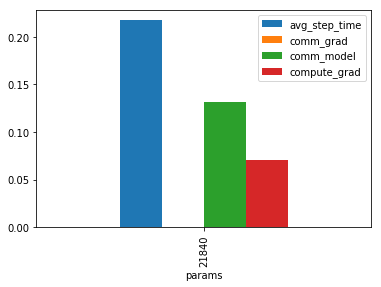

In [14]:
show = df.groupby('params').mean()
show.plot.bar()